In [1]:
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.utils import *
from keras.callbacks import *
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
import os
import xml.etree.ElementTree as ET
from skimage.io import imread
from PIL import Image
import warnings

warnings.filterwarnings("ignore")
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.config.list_physical_devices('GPU')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
dataset_folder_path = "D:/deep/datasets/stanford-dogs-dataset"
img_folders_path = dataset_folder_path + "/images/Images"
clipped_path = dataset_folder_path + "/clipped"
annots_path = dataset_folder_path + "/annotations/Annotation"
breed_dirs_list = os.listdir(img_folders_path)
num_classes = len(breed_dirs_list)
num_total_images = 0
dir_idx_map = {}
idx_dir_map = {}

os.mkdir(clipped_path)

for breed_dir in breed_dirs_list:
    os.mkdir(clipped_path + "/" + breed_dir)

clipped_dirs_list = os.listdir(clipped_path)

for breed_dir in breed_dirs_list:
    num_total_images += len(os.listdir(img_folders_path + "/{}".format(breed_dir)))

for i, v in enumerate(breed_dirs_list):
    dir_idx_map.update({v : i})
    idx_dir_map.update({i : v})

print("Классов: " + str(num_classes))
print("Изображений: " + str(num_total_images))

Классов: 120
Изображений: 20580


In [4]:
%%time

for breed_name in clipped_dirs_list:
    for file in os.listdir(annots_path + "/{}".format(breed_name)):
        img = Image.open(img_folders_path + "/{}/{}.jpg".format(breed_name, file))
        tree = ET.parse(annots_path + "/{}/{}".format(breed_name, file))
        xmin = int(tree.getroot().findall("object")[0].find("bndbox").find("xmin").text)
        xmax = int(tree.getroot().findall("object")[0].find("bndbox").find("xmax").text)
        ymin = int(tree.getroot().findall("object")[0].find("bndbox").find("ymin").text)
        ymax = int(tree.getroot().findall("object")[0].find("bndbox").find("ymax").text)

        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert("RGB")
        img = img.resize((224, 224))
        img.save(clipped_path + "/" + breed_name + "/" + file + ".jpg")

CPU times: total: 39 s
Wall time: 45 s


n02093991-Irish_terrier


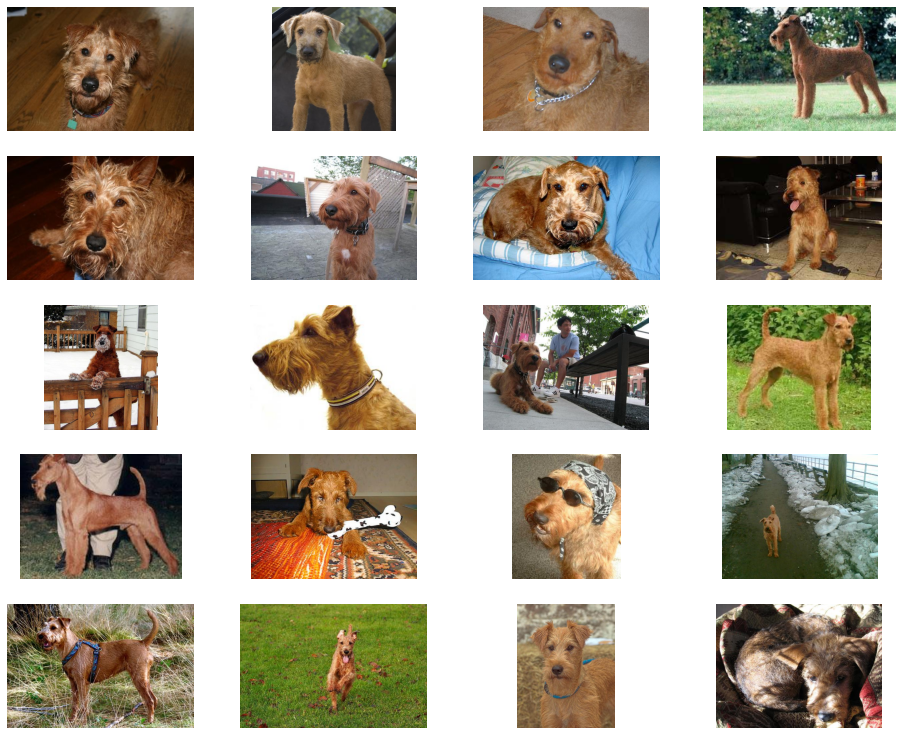

In [5]:
def print_images(dir_name, num_to_show):
    plt.figure(figsize=(16,16))
    dir_with_images = img_folders_path + "/" + dir_name
    images = os.listdir(dir_with_images)[:num_to_show]
    rows_num = int(num_to_show / 4 + 1)
    cols_num = 4
    for i in range(num_to_show):
        img = mpimg.imread(dir_with_images + "/" + images[i])
        position = i + 1
        plt.subplot(rows_num, cols_num, position)
        plt.imshow(img)
        plt.axis("off")

pointer=33
print(breed_dirs_list[pointer])
print_images(breed_dirs_list[pointer], 20)

In [6]:
class ImageGenerator(Sequence):

    def __init__(self, paths, targets, batch_size, shape):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape

    def __getitem__(self, batch_idx):
        start_path_idx = batch_idx * self.batch_size
        end_path_idx = (batch_idx + 1) * self.batch_size
        batch_paths = self.paths[start_path_idx : end_path_idx]

        X = np.zeros((len(batch_paths),
                      self.shape[0], self.shape[1], self.shape[2]),
                     dtype=np.float32)

        for i, path in enumerate(batch_paths):
            img = imread(path)
            img = preprocess_input(img)
            X[i] = img

        y = self.targets[start_path_idx : end_path_idx]

        return X, y

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item

    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

def paths_labels_targets():
    paths = list()
    labels = list()
    targets = list()

    for breed_name in breed_dirs_list:
        curr_breed_path = clipped_path + "/{}".format(breed_name)

        for img_name in os.listdir(curr_breed_path):
            paths.append(curr_breed_path + "/" + img_name)
            labels.append(breed_name)
            targets.append(dir_idx_map[breed_name])

    return paths, labels, targets

paths, labels, targets = paths_labels_targets()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = to_categorical(targets, num_classes=num_classes)
targets.shape

(20580, 120)

In [7]:
train_paths, valid_paths, train_targets, valid_targets = train_test_split(paths,
                                                                          targets,
                                                                          test_size=0.15,
                                                                          random_state=42)
train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3))
valid_gen = ImageGenerator(valid_paths, valid_targets, batch_size=32, shape=(224,224,3))


img_input = Input((224, 224, 3))

densenet_model = DenseNet121(input_tensor=img_input,
                       weights="imagenet",
                       include_top=False)

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
classes_output = Dense(num_classes, activation="softmax")(x)

model = Model(img_input, classes_output)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

for layer in model.layers[:-6]:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [9]:
%%time

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("dog-breed-classifier-densenet121.h5",
                             monitor="val_acc",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2,
                              patience=1,
                              verbose=1,
                              mode="min",
                              min_delta=0.0001,
                              cooldown=2,
                              min_lr=1e-7)

early_stop = EarlyStopping(monitor="val_loss",
                           mode="min",
                           patience=5)


history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=len(train_gen),
                              validation_data=valid_gen,
                              validation_steps=len(valid_gen),
                              epochs=10,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/10
547/547 [==============================] - 52s 89ms/step - loss: 2.1957 - accuracy: 0.4323 - val_loss: 0.7212 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - 46s 83ms/step - loss: 1.0998 - accuracy: 0.6601 - val_loss: 0.5818 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - 45s 82ms/step - loss: 0.9492 - accuracy: 0.7039 - val_loss: 0.5635 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - 45s 82ms/step - loss: 0.8807 - accuracy: 0.7313 - val_loss: 0.5404 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 5/10
547/547 [==============================] - 44s 81ms/step - loss: 0.8222 - accuracy: 0.7450 - val_loss: 0.5270 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 6/10
547/547 [==============================] - 44s 81ms/step - loss: 0.7944 - accuracy: 0.7511 - val_loss: 0.5169 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 7/10
547/547 [==============================] - 44s 

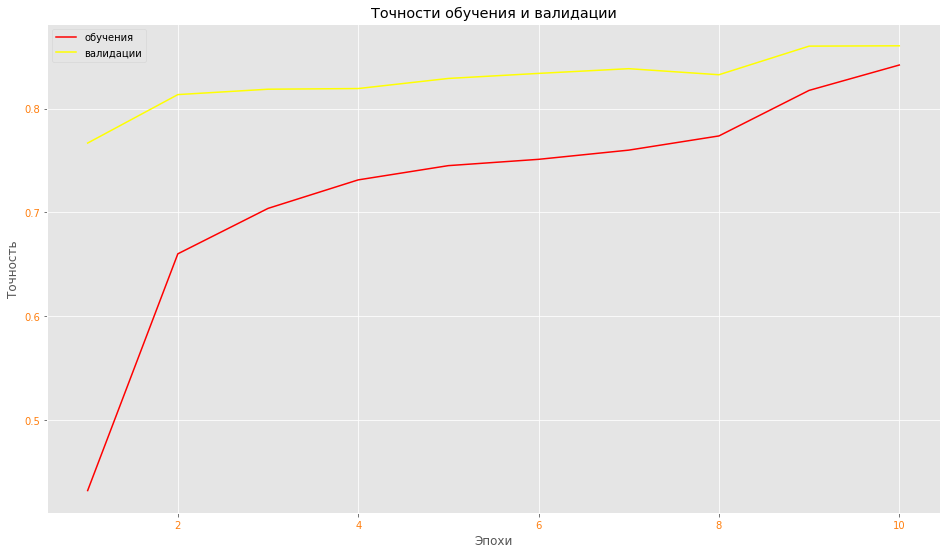

<Figure size 1152x648 with 0 Axes>

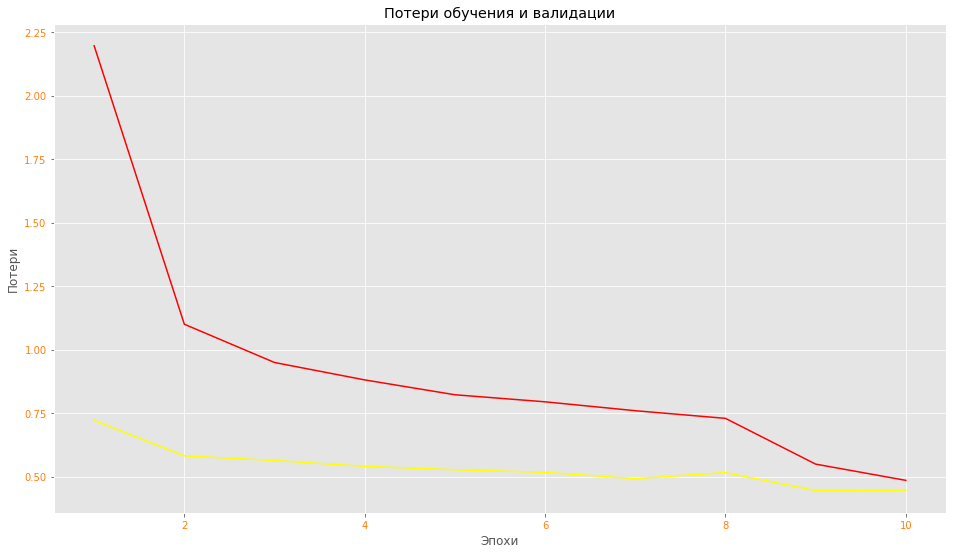

In [10]:
plt.rcParams["figure.figsize"] = (16,9)
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.tick_params(labelcolor='tab:orange')
plt.title("Точности обучения и валидации")
accuracy = history.history["accuracy"]
epochs = range(1, len(accuracy) + 1)
val_accuracy = history.history["val_accuracy"]
plt.plot(epochs, accuracy, "red", label='обучения')
plt.plot(epochs, val_accuracy, "yellow", label="валидации")
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.figure()
fig2, ax2 = plt.subplots()
ax2.tick_params(labelcolor='tab:orange')
plt.title("Потери обучения и валидации")
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "red", label="обучения")
plt.plot(epochs, val_loss, "yellow", label="валидации")
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

1/1 [==============================] - 2s 2s/step
99.11% 	 pekinese
0.35% 	 pomeranian
0.32% 	 brabancon_griffon
0.16% 	 leonberg
0.04% 	 japanese_spaniel
0.01% 	 tibetan_mastiff
0.00% 	 keeshond
0.00% 	 newfoundland
0.00% 	 chow
0.00% 	 lhasa


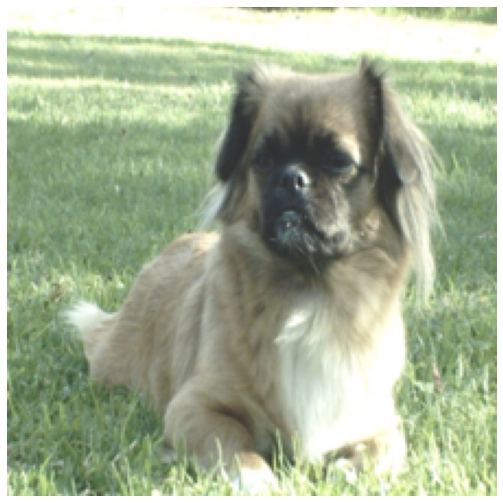

In [11]:
import json

def read_json(file_name: str):
    with open(file_name) as file_in:
        return json.load(file_in)

def predict(url, file_name):
    os.system("curl -s {} -o {}".format(url, file_name))
    img = Image.open(file_name)
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img.save(file_name)

    plt.figure(figsize=(9, 9))
    plt.imshow(img)
    plt.axis("off")

    img = imread(file_name)
    img = tf.keras.applications.densenet.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    probs = model.predict(img)

    for idx in probs.argsort()[0][::-1][:10]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", breed_names_map[str(idx)])

breed_names_path = "D:/deep/datasets/stanford-dogs-dataset/dog-classifier.json"
breed_names_map = read_json(breed_names_path)
predict("https://upload.wikimedia.org/wikipedia/commons/9/9b/Pequines.jpg", "test11.jpg")

1/1 [==============================] - 0s 21ms/step
10.68% 	 dingo
9.80% 	 chihuahua
4.73% 	 brabancon_griffon
4.30% 	 pomeranian
3.41% 	 eskimo_dog
3.06% 	 dhole
3.00% 	 pekinese
2.62% 	 pembroke
2.41% 	 kelpie
2.30% 	 basenji


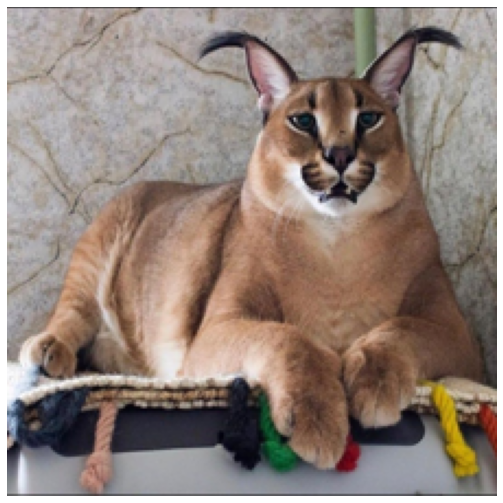

In [38]:
predict("https://funart.pro/uploads/posts/2021-07/1625591994_18-funart-pro-p-shlyopa-kot-zhivotnie-krasivo-foto-35.jpg", "test77.jpg")

1/1 [==============================] - 0s 20ms/step
43.29% 	 curly_coated_retriever
22.53% 	 flat_coated_retriever
12.83% 	 scottish_deerhound
2.94% 	 bouvier_des_flandres
2.27% 	 giant_schnauzer
1.90% 	 chesapeake_bay_retriever
1.84% 	 standard_schnauzer
1.71% 	 irish_wolfhound
1.41% 	 kerry_blue_terrier
0.93% 	 newfoundland


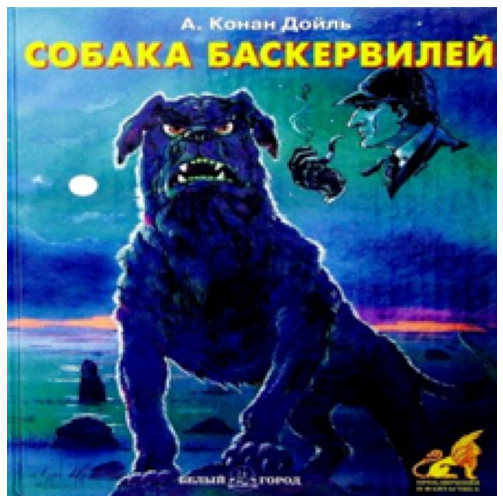

In [39]:
predict("https://img4.labirint.ru/rc/38b4a890dc04025ad1b7d1a96caf33de/363x561q80/books5/49742/cover.jpg?1280394613", "test66.jpg")

1/1 [==============================] - 0s 22ms/step
93.89% 	 tibetan_terrier
4.62% 	 lhasa
1.11% 	 shih_tzu
0.14% 	 old_english_sheepdog
0.12% 	 briard
0.05% 	 dandie_dinmont
0.02% 	 maltese_dog
0.02% 	 otterhound
0.01% 	 soft_coated_wheaten_terrier
0.01% 	 silky_terrier


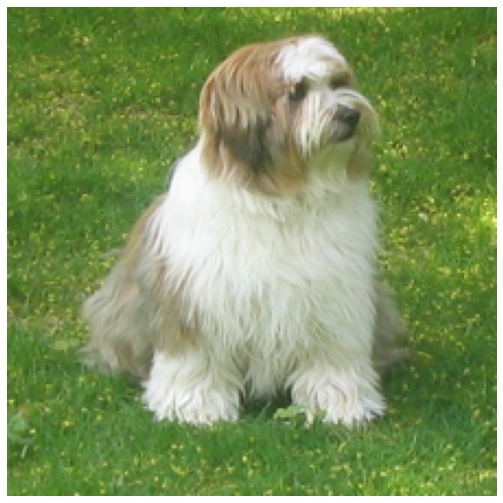

In [40]:
predict("https://upload.wikimedia.org/wikipedia/commons/f/f7/Tibetan_Terrier_Image_001.jpg", "test55.jpg")

1/1 [==============================] - 0s 20ms/step
100.00% 	 afghan_hound
0.00% 	 briard
0.00% 	 saluki
0.00% 	 tibetan_terrier
0.00% 	 cocker_spaniel
0.00% 	 silky_terrier
0.00% 	 leonberg
0.00% 	 lhasa
0.00% 	 otterhound
0.00% 	 irish_setter


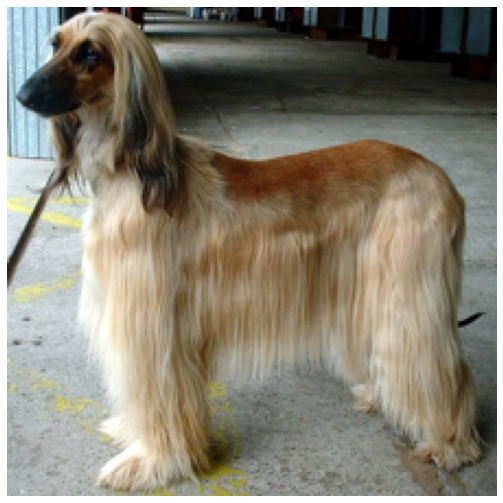

In [41]:
predict("https://upload.wikimedia.org/wikipedia/commons/f/fe/Afghan_Hound.jpg", "test44.jpg")

1/1 [==============================] - 0s 24ms/step
97.35% 	 shih_tzu
2.39% 	 lhasa
0.12% 	 japanese_spaniel
0.05% 	 blenheim_spaniel
0.05% 	 pekinese
0.03% 	 tibetan_terrier
0.00% 	 maltese_dog
0.00% 	 french_bulldog
0.00% 	 boxer
0.00% 	 cocker_spaniel


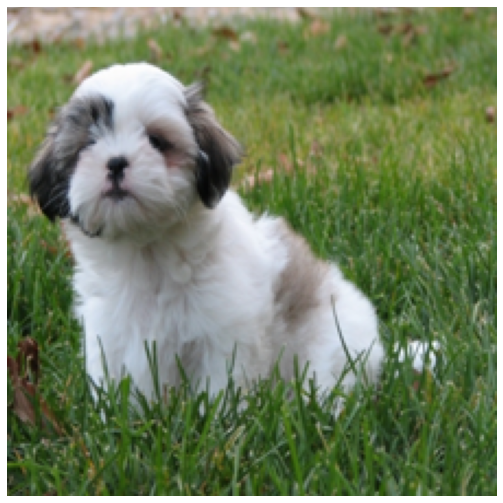

In [42]:
predict("https://upload.wikimedia.org/wikipedia/commons/b/bc/ShihTzuPup.jpg", "test33.jpg")

1/1 [==============================] - 0s 39ms/step
99.98% 	 chow
0.02% 	 tibetan_mastiff
0.00% 	 pomeranian
0.00% 	 newfoundland
0.00% 	 keeshond
0.00% 	 samoyed
0.00% 	 collie
0.00% 	 golden_retriever
0.00% 	 shetland_sheepdog
0.00% 	 pekinese


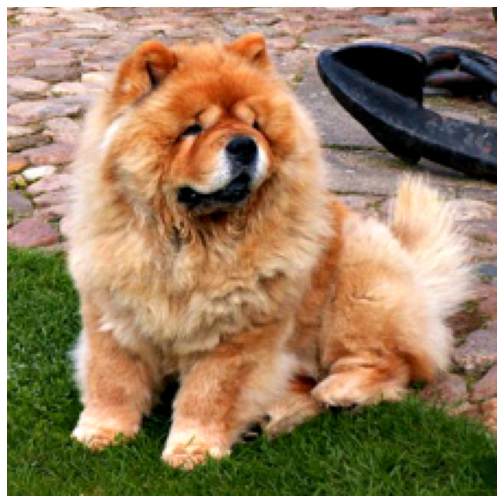

In [43]:
predict("https://upload.wikimedia.org/wikipedia/commons/6/6d/Shiva%2C_aug-05-5.jpg", "test22.jpg")

1/1 [==============================] - 0s 167ms/step
100.00% 	 curly_coated_retriever
0.00% 	 flat_coated_retriever
0.00% 	 irish_water_spaniel
0.00% 	 chesapeake_bay_retriever
0.00% 	 german_short_haired_pointer
0.00% 	 nstandard_poodle
0.00% 	 labrador_retriever
0.00% 	 kerry_blue_terrier
0.00% 	 kuvasz
0.00% 	 newfoundland


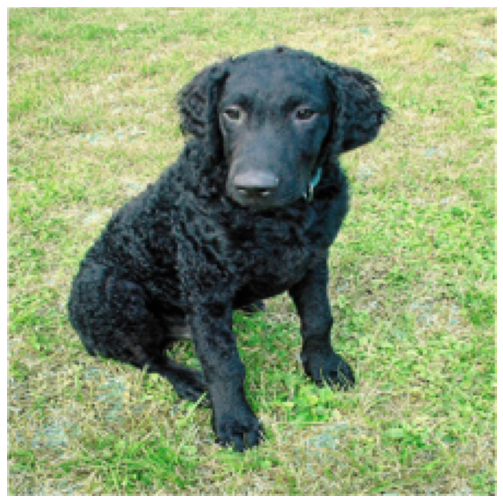

In [12]:
predict("https://upload.wikimedia.org/wikipedia/commons/7/71/Curly_Coated_Retriever_-_001.jpg", "test555.jpg")